# Building an image recognition web app with fastai v2

In this notebook I will walk through the process of building a simple image recognition web app with [fastai v2](http://dev.fast.ai/), closely following chapter 2 of the draft of [fastai book](https://github.com/fastai/fastbook), which will be officially released in July 2020. The problem I want to solve is to build an image classification model that can distinguish between different types of acoustic guitars. The four types I chose are [dreadnought](https://www.bing.com/images/search?q=dreadnought+guitar&scope=images&form=QBLH&sp=-1&pq=dreadnought+guitar&sc=6-18&qs=n&sk=&cvid=361D728C992E4FDA98D42C0202504A4C) and [jumbo](https://www.bing.com/images/search?q=jumbo%20guitar&qs=n&form=QBIR&scope=images&sp=-1&pq=jumbo%20guitar&sc=8-12&sk=&cvid=B56651D5293C4DE0B54CD4DF290E8906), which are both western guitars, [classical guitars](https://www.bing.com/images/search?q=classical%20guitar&qs=n&form=QBIR&scope=images&sp=-1&pq=classical%20guitar&sc=8-16&sk=&cvid=2A870A59F623457986FFB86383DB3A08) and [resonator guitars](https://www.bing.com/images/search?q=resonator%20guitar&qs=n&form=QBIR&scope=images&sp=-1&pq=resonato%20guitar&sc=8-15&sk=&cvid=0E2335DE50574F0F92BDFE8671087845).

I will cover the following steps:
1. Data acquisition with Bing image search API
2. DataBlock API, image transformation and data augmentation
3. Fine-tuning a pre-trained ResNet18 on a new task
4. Using the model's predictions to clean the data
5. Preparing the fine-tuned model for deployment
6. Deployment as a simple web app (separate [notebook](https://github.com/stefan-jo/guitar_classifier/blob/master/guitar_classifier_webapp.ipynb))

Import fastai2 for computer vision and the corresponding utils file

In [1]:
from utils import *
from fastai2.vision.widgets import *

In [4]:
# Check if GPU is available
torch.cuda.is_available()

True

Since there appeared some non-relevant warnings in the code, let's suppress all warnings at this point

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Downloading data with Bing search API

For using the Bing image search API, you need to set up a Microsoft Azure account (credit card required) and sign up for a free 7 day trial of Azure Cognitive Services. After you went through this process and obtained your key for authentication, paste it here.

In [4]:
key = 'YOUR_KEY'

Let's have a look at the source code of fastai's `search_image_bing` function

In [4]:
search_images_bing??

What `search_images_bing` does:
- set up the client: Azure Cognitive services API and authentication key
- send a request to the Bing image search API with search term, image count and minimum size

I will slightly modify the function so that the number of queried images (`n_imgs`) can be changed easily

In [5]:
def search_images_bing(key, term, n_imgs=150, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=n_imgs, min_height=min_sz, min_width=min_sz).value)

Let's download one image to make sure the API is working

In [6]:
results = search_images_bing(key, 'dreadnought guitar', n_imgs=1)
ims = results.attrgot('content_url')
len(ims)

1

We now have the url of the first image of type dreadnought guitar. Let's now download that image, save it to `dest` and display the image.

In [7]:
dest = 'images/example_guitar.jpg'
download_url(ims[0], dest)

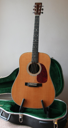

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

Seems like it's working fine. 

Next, let's define a list of all classes by using a list comprehension

In [33]:
classes = 'dreadnought','jumbo','resonator','classical'
classes = [o + ' guitar' for o in classes]
classes

['dreadnought guitar', 'jumbo guitar', 'resonator guitar', 'classical guitar']

Specify the path where the downloaded images should be saved

In [12]:
path = Path('/storage/fastai_v2/guitars')
path.mkdir(exist_ok=True)
path

Path('/storage/fastai_v2/guitars')

The `for loop` below goes through our list of classes and carries out the following steps:
1. the first two lines create a sub-directory for each class with the short class name (e.g. dreadnought)
2. get urls of 150 images for one class at a time by searching Bing for the full class name (e.g. dreadnought guitar)
3. download the actual images to the specified destination
4. print out how many images have been downloaded (for some reason the API sometimes returns less than 150 images)

In [13]:
# Only run this cell when you want to download images
for o in classes:
    dest = (path/o.split()[0])
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, o, n_imgs=150)
    download_images(dest, urls=results.attrgot('content_url'))
    print(f'{len(dest.ls())} images downloaded for {o}')

148 images downloaded for dreadnought guitar


150 images downloaded for jumbo guitar


150 images downloaded for resonator guitar


150 images downloaded for classical guitar


In [2]:
148+150*3

598

The fastai function `get_image_files` returns the number of image files in `path` and prints out a few examples. Since the total number of downloaded files was 598 and we have 596 image files, it looks like two non-image files have been downloaded

In [14]:
fns = get_image_files(path)
fns

(#596) [Path('/storage/fastai_v2/guitars/resonator/00000049.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000024.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000035.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000022.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000129.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000050.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000115.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000010.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000120.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000144.jpg')...]

`verify_images` goes through the downloaded image files and finds corrupted files that cannot be opened

In [17]:
failed = verify_images(fns)
failed

(#20) [Path('/storage/fastai_v2/guitars/resonator/00000066.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000075.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000079.jpg'),Path('/storage/fastai_v2/guitars/classical/00000049.jpg'),Path('/storage/fastai_v2/guitars/classical/00000118.jpg'),Path('/storage/fastai_v2/guitars/classical/00000122.jpg'),Path('/storage/fastai_v2/guitars/classical/00000097.jpg'),Path('/storage/fastai_v2/guitars/classical/00000002.jpg'),Path('/storage/fastai_v2/guitars/classical/00000085.jpg'),Path('/storage/fastai_v2/guitars/classical/00000045.jpg')...]

The 20 corrupted files stored in `failed` can easily be removed by using `Path.unlink`

In [18]:
failed.map(Path.unlink);

In [20]:
fns = get_image_files(path)
fns

(#576) [Path('/storage/fastai_v2/guitars/resonator/00000049.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000024.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000035.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000022.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000129.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000050.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000115.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000010.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000120.jpg'),Path('/storage/fastai_v2/guitars/resonator/00000144.jpg')...]

We now have a total of 576 working image files for training our model. Let's move on..

## Creating unique filenames

The `ImageClassifierCleaner` below threw some errors due to conflicting filenames (e.g. 00000000.jpg, 00000001.jpg, 00000002.jpg exist in all sub-directories). So I will rename all files to make them unique by adding the first letter of the respective class to each filename.

In [34]:
classes

['dreadnought guitar', 'jumbo guitar', 'resonator guitar', 'classical guitar']

In [46]:
dirs = [o.split()[0] for o in classes]
dirs

['dreadnought', 'jumbo', 'resonator', 'classical']

I will loop though the four sub-directories (one for each class) and change each filename one at a time using `os.rename` as specified

In [65]:
for d in dirs:
    for fn in os.listdir(path/d):
        os.rename(path/d/fn, path/d/(str(d[0])+'_'+fn))

Having a look at some renamed files

In [71]:
os.listdir(path/'classical')[:5]

['c_00000030.jpg',
 'c_00000042.jpg',
 'c_00000032.jpg',
 'c_00000012.jpg',
 'c_00000087.jpg']

## Preparing the data for training with the DataBlock API

Until now, all we did was to collect the data and store it, so that we can now move on to prepare the data for training an image classificaiton model (which will be done in the next part). 

When you re-run this notebook, you can skip the first two parts, but then you need to specify the path here.

In [4]:
path = Path('/storage/fastai_v2/guitars')

fastai method `path.ls()` basically adds the functionality from `os.listdir()` to a `pathlib` `Path` object, which lists all files in a directory and in addition returns the number of files in the directory.

In [5]:
path.ls()

(#5) [Path('/storage/fastai_v2/guitars/.ipynb_checkpoints'),Path('/storage/fastai_v2/guitars/resonator'),Path('/storage/fastai_v2/guitars/classical'),Path('/storage/fastai_v2/guitars/dreadnought'),Path('/storage/fastai_v2/guitars/jumbo')]

Now I will make use of the powerful `DataBlock` API, which let's you transform data of different types and formats into data suitable for training a machine learning model. In this case, the following steps are specified:
- `blocks`: here we specify which kind of independent variable (`ImageBlock`) and dependent variable (`CategoryBlock`) we have
- `get_items`: a function which specifies how to get the data (I already used `get_image_files` above)
- `splitter`: `RandomSplitter` divides the dataset into training and validation set. Here, a random 20% validation set is used
- `get_y`: defines how to get the labels. `parent_label` gets the labels from the folder name where the files are stored
- `item_tfms`: all kinds of transformations that are applied to the inputs can be added here. More on this soon

In [6]:
git_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

After defining the `DataBlock` above, the method `git_db.dataloaders(path)` returns PyTorch `DataLoader` objects for training and validation sets 

In [7]:
dls = git_db.dataloaders(path)

`dls.vocab` returns the names of our categories

In [8]:
dls.vocab

(#4) ['classical','dreadnought','jumbo','resonator']

The lenghts of training and validations sets can be accessed through `dls.train_ds` and `dls.valid_ds`, respectively

In [9]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(455, 113, 568)

Default batch size in fastai is 64

In [10]:
dls.bs

64

Let's have a look at some of the images and their corresponding classes

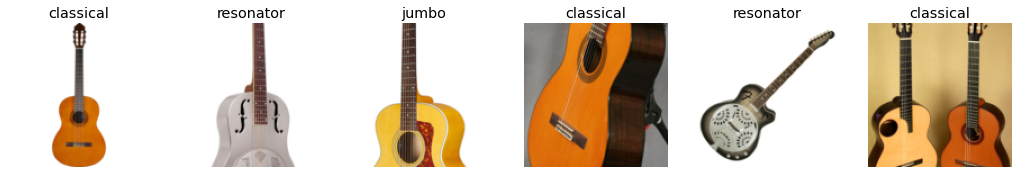

In [11]:
dls.valid.show_batch(max_n=6, nrows=1)

### Image transformation

Before moving on to training our image classifier, let's have a quick look at the different types of image transformations that fastai offers out-of-the-box.

For training a neural network for image classification, the images in a batch of data all need to have the same size. But since images in reality come in many different sizes, we need to find a way to resize them. By default, fastai will crop the images, but this risks losing some important features which appear towards the edges of an image.

For demonstrating differnet types of transformations, I will create a copy of the original `DataBlock` with a different method for resizing. 

`ResizeMethod.Squish` does exactly what the name suggests, i.e. it squishes or stretches the images so that the are square with 128x128 pixels. One obvious problem here is that it can change the image so far that it no longer represents a realistic image of a given object.

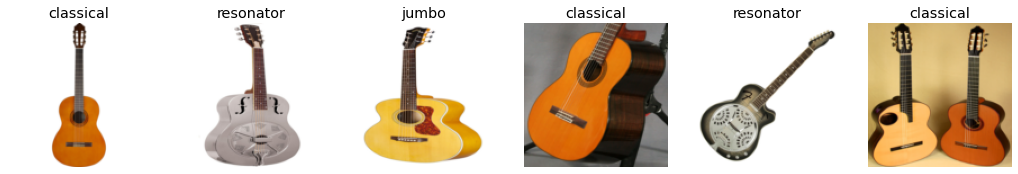

In [12]:
git_db = git_db.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = git_db.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=1)

`ResizeMethod.Pad` adds zero padding (i.e. black space) around an image to make it square. This method keeps the image in realistic proportions, but on the other hand wastes a lot of space by adding zeros and also makes the object of interest smaller.

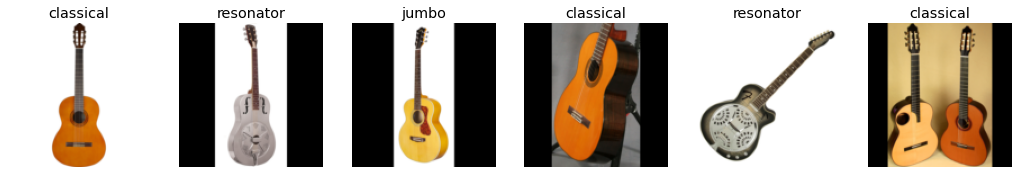

In [13]:
git_db = git_db.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = git_db.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=1)

An interesting fastai method is `RandomResizedCrop`, which returns a random crop of the original image with at least `min_scale` of the original image size. The best thing about this method is that it returns a different version of the same image *at every epoch* and thus can also reduce overfitting since it makes it harder for the model to memorize the images in the training set.

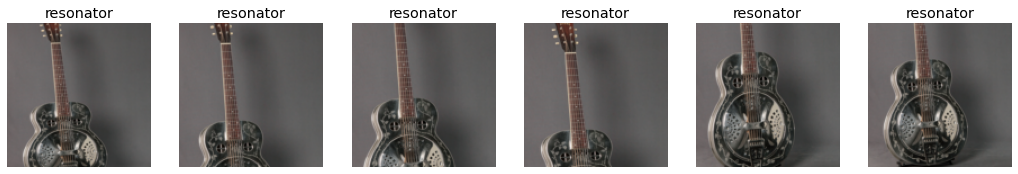

In [14]:
git_db = git_db.new(item_tfms=RandomResizedCrop(128, min_scale=0.5))
dls = git_db.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=6, nrows=1)

### Data augmentation

A powerful tool to artificially increase the dataset size and reduce overfitting is called data augmentation. This is especially useful for small datasets like this one. There are many different data augmentation techniques and fastai's `aug_transforms` includes the most common ones, such as flipping, rotating, zooming and perspective warping. Each of these augmentations can be fine-tuned by changing the hyper-parameters of the function. It's also possible to scale the overall augmentation strength by changing `mult=1.0`. I will leave it at the default values since they work very well in many settings.

A cool detail I want to mention is `pad_mode='reflection'` which, rather than simply using zeros, uses the reflection of pixel values to fill excess space, which in many settings leads to reasonable (but of course not perfect) pixel extrapolations.

For checking out the details, see the documentation with `doc` or the source code with `??`

In [15]:
doc(aug_transforms)

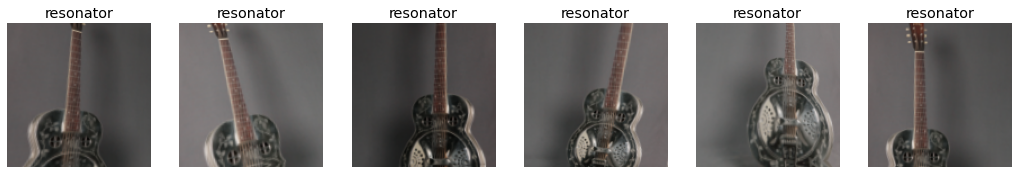

In [16]:
git_db = git_db.new(item_tfms=Resize(128), batch_tfms=aug_transforms(pad_mode='reflection'))
dls = git_db.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=6, nrows=1)

## Training the first model

Since the best type of image transformation and augmentation most likely depends on the exact problem you are working on, I would recommend trying out different transformation/augmentation types, training a model on *the same subset* of data and comparing the results.

Here, I will use `RandomResizedCrop` with size 224x224 and `min_scale` of 0.5 and the default fastai data augmentations.

Note that there are `item_tfms` which are applied to each item/image separately and `batch_tfms` which are applied to all images in a batch of data at the same time. Since each image comes in a different size, we need to resize one item at a time. But because after resizing all images have the same size, we can apply data augmentation to all 64 images in a batch at the same time on the GPU, which speeds up the process.

In [17]:
git_db = git_db.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = git_db.dataloaders(path)

In [18]:
dls.vocab

(#4) ['classical','dreadnought','jumbo','resonator']

In [19]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(455, 113, 568)

In the next two lines of code we will be finally training our image classification model. A `learner` object in fastai combines our data in the form of `DataLoaders`, a model architecture (optionally with pre-trained parameters) and a metric we care about.

Here I use `ResNet18`, a convolutional neural network architecture introduced by [He et al. (2015)](https://arxiv.org/abs/1512.03385) that set a new state-of-the-art for the famous [ImageNet dataset](https://en.wikipedia.org/wiki/ImageNet) in 2015. One of the key innovations from the paper was the introduction of residual connections which allow to train much deeper neural networks than before. `ResNet18` is a small version with only 18 layers (in the paper the authors trained a `ResNet152`) that is nevertheless powerful and very fast to train.

Since fastai makes use of transfer learning wherever possible, by default `cnn_learner` will download pretrained weights  (`pretrained=True`) from the internet for the specified architecture. For understanding transfer learning, it is best to imagine that the network consists of two parts:
1. *The head*: these are the final task-specific (i.e. classifying guitar types) layers of the network which are initialized with random values
2. *The body*: this is the rest of the network which is initialized with the weights from the pre-trained model. Here, the model has been pre-trained on the much larger ImageNet dataset mentioned above. 

The key idea of transfer learning is that, even though the pre-trained model has been trained on an entirely different task, its weights contain important information for recognizing low-level features in images which is useful for other tasks as well. This technique makes it possible to train neural networks much faster and obtain higher accuracy. It is especially powerful when the dataset used during pre-training was very large relative to the task-specific dataset.

A new method in fastai v2 is `learn.fine_tune()` which will first train only the head for one epoch with all other layers frozen, then unfreeze the entire model and train it for the specified number of epochs.

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.973319,0.923632,0.362832,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.996303,0.731931,0.265487,00:11
1,0.899139,0.693047,0.221239,00:11
2,0.780464,0.647774,0.203540,00:11
3,0.675124,0.612604,0.203540,00:10


An error rate of 20% for uncleaned images from the internet is actually not bad in this setting, but I believe we can do better.

Always when you have more than two classes, it is useful to look at the results in more detail in order to find out where the model actually makes mistakes. For this reason, I will plot the confusion matrix for the validation set. The matrix shows the predictions on the x-axis and the actual classes on the y-axis. The diagonal from the upper left to lower right represents correct predictions. The other fields show us where the model made mistakes.

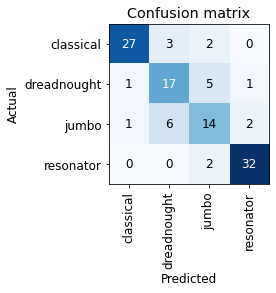

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

To understand the mistakes the model makes better, it is useful to plot the highest losses. This can be cases where the model made a wrong prediction and was confident about it or made a correct prediction but was very unconfident.

While the model made a clear mistake in the first image, the other three cases present nice examples of understanding *why* the model got it wrong:
- The second example has a weird perspective, so that the guitar body doesn't clearly look like dreadnought or jumbo. I would have to guess this one myself. Also, the strange white surfaces on the body might confuse the model.
- The third example is mislabeled, since it is clearly a dreadnought guitar. So the model actually got it right.
- The fourth example shows only the guitar head, which is not enough to distinguish between guitar types.

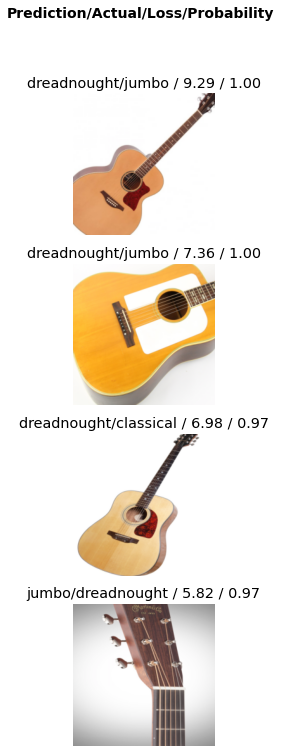

In [22]:
interp.plot_top_losses(4, nrows=4, largest=True)

It can also be insightful to look at the lowest losses to understand what the model already knows perfectly. It's not very surprising that all four top losses are resonator guitars, since its design includes a very characteristic resonator cone. Such a distinctive feature should be easy for the model to pick up.

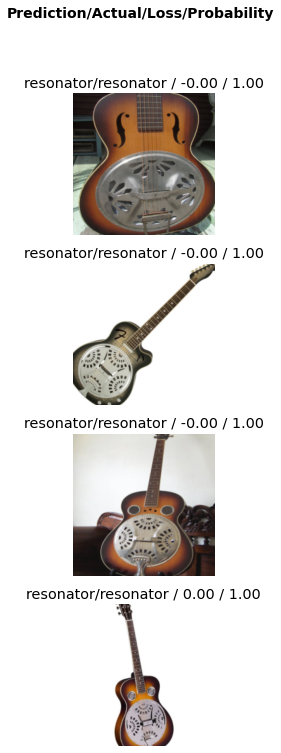

In [23]:
interp.plot_top_losses(4, nrows=4, largest=False)

As we have seen above, our dataset contains some mislabeled examples which should be fixed. This is a nice example of using a machine learning model for cleaning data. Since we downloaded and labeled data by search term, it is clear that the dataset will contain some mistakes. However, most of the images should correspond to the correct label. So we can quickly train a first model that helps us find mislabeled images. This procedure can drastically speed up the tedious and time-consuming process of data cleaning. 

`ImageClassifierCleaner` is a super useful fastai tool developed with [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) that lets the user click through the different classes in training and validation sets and change the label of images or delete them altogether if needed.

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="1000" src="image_cleaner.JPG">

The image cleaner above only tags images as *keep*, *delete* or *change label*, but to actually delete images or change their label by moving them to another sub-directory, the following two cells must be executed.

*Correct process for data cleaning:*
1. Start with one combination, e.g. dreadnought and training set  
2. Mark all images you want to change or delete
3. Run the two cells below to execute all changes
4. Change only one part of the combination, e.g. dreadnought → jumbo OR training set → validation set
5. Go back to step 2 

Iteratively go through all combinations of classes and training/validation set like this until you're done

In [31]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Retraining after data cleaning

Since we now have a clean dataset, I will run through the same steps as above once more

In [36]:
git_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = git_db.dataloaders(path)

In [37]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(432, 108, 540)

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,2.086579,1.836510,0.425926,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.160848,0.997580,0.342593,00:11
1,0.950253,0.602237,0.259259,00:12
2,0.800888,0.563160,0.212963,00:11
3,0.680501,0.425556,0.138889,00:11
4,0.595887,0.412141,0.129630,00:11
5,0.544772,0.411925,0.129630,00:12


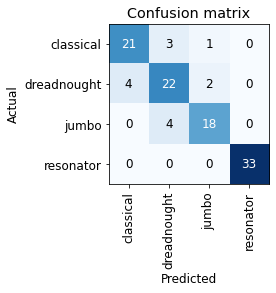

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

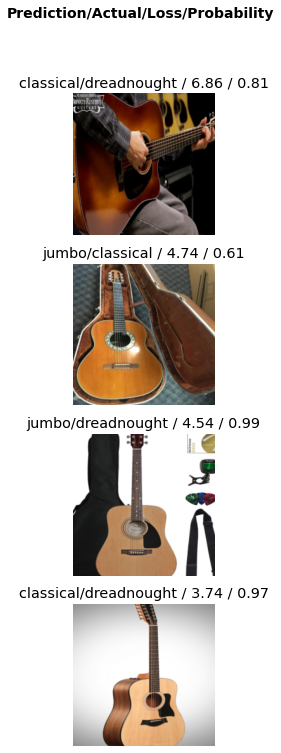

In [42]:
interp.plot_top_losses(4, nrows=4, largest=True)

By cleaning a couple of images, we brought down the error rate from 20 to 13%. The model clearly improved. It got all resonator guitars right but confused a few images of the other guitar types. Looking at the top losses, it becomes obvious that the model mostly confuses images which do not only show the guitar, but also some player, a case or other items. Example four is also quite interesting. Even though it is clearly of type dreadnought, the guitar on the image is presented from a perspective which is most characteristic for classical guitars. That might be the reason why the model got it wrong.

## Preparing the model for deployment

By doing another round of data cleaning and re-training, the error rate could probably be lowered a bit more, but I am happy with the result we already got so I'm moving on to the next step. I want to deploy the trained model to a simple web app which allows users to upload pictures of their acoustic guitars and automatically classify them. Of course the model is not perfect, but as long as users are uploading relatively clean images it should do a good job.

### Saving the model

When we export a model, fastai saves the model architecture, the corresponding weights and information about the way the `DataLoaders` have been created. I want to stress that the last part is very useful, since otherwise we would need to pre-process the data during inference in the same way as above.

In [43]:
learn.export()

In [44]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Inference

Finally I want to try the model during inference, i.e. use the trained model to make a prediction on a new image. 

All you need to do is the following:
- Get an image and save it somewhere
- Run the model on the image to get a prediction
- Check if the prediction is correct

(note that this image has been part of the training set but in reality you would test the model on unseen data)

In [5]:
path = Path()

In [6]:
learn_inf = load_learner(path/'export.pkl')

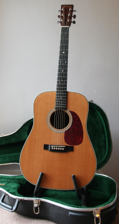

In [7]:
im = Image.open('images/example_guitar.jpg')
im.to_thumb(224,224)

The model outputs the name of the predicted class, the index of the predicted class and the predicted probabilities for all classes

In [8]:
pred = learn_inf.predict('images/example_guitar.jpg')
pred

('dreadnought', tensor(1), tensor([0.1057, 0.8005, 0.0767, 0.0171]))

The class names, which are also stored in `learner`, map to the index of the predicted class and the predicted probabilities

In [9]:
learn_inf.dls.vocab

(#4) ['classical','dreadnought','jumbo','resonator']

In [10]:
print(f'Class {pred[0]} was predicted with probability {pred[2][pred[1]]}')

Class dreadnought was predicted with probability 0.800520122051239


## Deployment

I went on and deployed my model as a simple web app prototype using the following tools:
- I wrote all the code in a [Jupyter](https://jupyter.org/) notebook such as this one
- [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) let's you configure the interactive layout of your web app, e.g. by adding buttons and text fields
- [Voila](https://voila.readthedocs.io/en/stable/index.html) converts a notebook into an app that can be shared with others by displaying only markup and cell outputs. A notebook can be turned into a Voila app by installing Voila, connecting the Jupyter notebook to it and replacing "notebooks" in the url with "voila/render"
- You need to save your notebook, trained model, requirements file and fastai utils file in a [Github](https://github.com/) repository
- Deploy your web app for free with [Binder](https://mybinder.org/) by entering your github repository, select URL to open and enter the filename of the notebook that contains the app in the following format: /voila/render/notebook_name.ipynb

**Feel free to check out my final web app [here](), the corresponding github repo [here](https://github.com/stefan-jo/guitar_classifier) and the notebook for creating the app [here](https://github.com/stefan-jo/guitar_classifier/blob/master/guitar_classifier_webapp.ipynb)**

Thanks for reading :-)